# **PyTorch Osnove 3: Trening, Monitoring i Evaluacija**

**Kurs:** KSMF1  
**Trajanje:** ~45 min  
**Preduslovi:** Razumevanje PyTorch modula i optimizatora (PyTorch Osnove 2)
---

## Ciljevi Sekcije

Do kraja ove sekcije, naučićete da:

- Razumeti kako izgleda jednostavan PyTorch radni tok (workflow)
- Izgraditi kompletne trening petlje neuronskih mreža
- Pratiti napredak treniranja sa praćenjem gubitka i vizualizacijom
- Proceniti performanse modela koristeći česte metrike
---

# **Deo 5: Treniranje Modela**

Sada kada znamo kako da izgradimo naše modele, pravimo predviđanja pomoću njih i koristimo optimizatore da ih naučimo, vreme je da sve spojimo u kompletnu petlju za treniranje!

Rešićemo jednostavan **1-dimenzionalni problem linearne regresije** kao demonstraciju.


In [ ]:
# Učitajmo PyTorch i druge važne biblioteke
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Postavi random seed za reproducibilnost
torch.manual_seed(42)
print("PyTorch version:", torch.__version__)

## 5.1 Trening Petlja

Trening petlja je proces koji uzima ulazne podatke, provlači ih kroz našu mrežu da dobije izlaz, meri koliko je loše mreža predvidela izlaz i koristi optimizator da podesi parametre koji se mogu trenirati na osnovu tih informacija. Ovaj proces se ponavlja sve dok model ne minimizuje gubitak.

### Kreiranje Lažnih Podataka

Za potrebe ove demonstracije, kreiračemo naše sopstvene izmišljene podatke koji dolaze is procesa: **y(x) = 3x + 2 + šum**. To znači da ćemo znati pravi proces koji generiše naše podatke, ali **pretvaraćemo se da ne znamo**.

Cilj će biti **da naučimo ovaj proces** (ili preciznije, da naučimo **w i b** u **y(x) = wx + b**) pretvarajući se da imamo pristup samo podacima koje je proces generisao, jer tako funkcionišu stvarni problemi.

In [ ]:
# Generisaćemo sintetičke podatke za linearnu regresiju
# Kreiraćemo podatke koji prate: y = 3x + 2 + šum
torch.manual_seed(42)
n_samples = 100
true_slope = 3.0
true_intercept = 2.0

# Generiši ulazne podatke
x_train = torch.randn(n_samples, 1) * 2  # Nasumične x vrednosti

# Generiši ciljne podatke sa nekim šumom
y_train = true_slope * x_train + true_intercept + torch.randn(n_samples, 1) * 0.5

print("=== Linear Regression Dataset ===")
print(f"Number of samples: {n_samples}")
print(f"True relationship: y = {true_slope}x + {true_intercept}")
print(f"Input shape: {x_train.shape}")
print(f"Target shape: {y_train.shape}")

# Vizualizuj podatke
plt.figure(figsize=(8, 6))
plt.scatter(x_train.numpy(), y_train.numpy(), alpha=0.6, s=30)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Training Data: y = {true_slope}x + {true_intercept} + noise')
plt.grid(True, alpha=0.3)

# Nacrtaj pravu liniju
x_line = torch.linspace(x_train.min(), x_train.max(), 100)
y_line = true_slope * x_line + true_intercept
plt.plot(x_line.numpy(), y_line.numpy(), 'r--', linewidth=2, label='True Relationship')
plt.legend()
plt.show()

### Priprema Modela, Funkcije Gubitka i Optimizatora

Sada kada imamo naše podatke, hajde da izgradimo model i odaberemo funkciju gubitka i optimizator.

Pošto smo pogledali naše podatke, imamo dobar razlog da verujemo da dolaze iz 1-dimenzionalnog linearnog procesa (zapamtite, pretvaramo se da ne znamo pravu vezu). To znači da ćemo izgraditi **1D model linearne regresije**.

Ovaj model je vrlo jednostavan: To je jedan linearni sloj sa jednim ulazom i jednim izlazom. Pošto je u pitanju linearna regresija, znamo da je najbolja funkcija gubitka MSE. Takođe, izabraćemo Adam optimizator jer je najčešći.

In [ ]:
# Definiši model linearne regresije
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # 1 ulazna karakteristika, 1 izlaz

    def forward(self, x):
        return self.linear(x)

    # Opciona metoda koja nam pomaže da vizualizujemo rezultate kasnije
    def get_parameters(self):
        """Helper metoda da dobijemo nagib i odsečak"""
        weight = self.linear.weight.item()
        bias = self.linear.bias.item()
        return weight, bias

# Kreiraj model, funkciju gubitka i optimizator
model = LinearRegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print("=== Model Setup ===")
print(f"Model: {model}")
print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")

# Proveri početne parametre
initial_weight, initial_bias = model.get_parameters()
print(f"\nInitial parameters:")
print(f"Weight (slope): {initial_weight:.4f}")
print(f"Bias (intercept): {initial_bias:.4f}")
print(f"Target parameters: weight={true_slope}, bias={true_intercept}")

### Jednostavna Trening Petlja

Svaka petlja za treniranje sastoji se od sledećih 5 koraka:

1.   FORWARD PASS: Napravi predviđanja
2.   IZRAČUNAJ GUBITAK: Koliko smo pogrešili?
3.   POSTAVI GRADIJENTE NA NULU: Obriši prethodne gradijente (gradijenti se gomilaju u optimizatoru)
4.   BACKWARD PASS: Izračunaj gradijente za trenutni korak
5.   AŽURIRAJ PARAMETRE: Napravi korak optimizacije - gradijentni spust

In [ ]:
print("=== Training Loop ===")

# Kreiraj model, funkciju gubitka i optimizator
model = LinearRegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Podešavanja treniranja
num_epochs = 100
print_every = 20

# Skladištenje za praćenje napretka
loss_history = []
weight_history = []
bias_history = []

print(f"Starting training for {num_epochs} epochs...")
print("-" * 50)

for epoch in range(num_epochs):
    # 1. FORWARD PASS: Napravi predviđanja
    predictions = model(x_train)

    # 2. IZRAČUNAJ GUBITAK: Koliko smo pogrešili?
    loss = criterion(predictions, y_train)

    # 3. POSTAVI GRADIJENTE NA NULU: Obriši prethodne gradijente
    optimizer.zero_grad()

    # 4. BACKWARD PASS: Izračunaj gradijente za ovaj korak
    loss.backward()

    # 5. AŽURIRAJ PARAMETRE: Napravi korak optimizacije
    optimizer.step()

    # Opciono: Prati i ispiši napredak - Postoje ugrađene metode za ovo uključene u PyTorch
    loss_history.append(loss.item())
    weight, bias = model.get_parameters()
    weight_history.append(weight)
    bias_history.append(bias)

    if (epoch + 1) % print_every == 0:
        print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
              f"Loss: {loss.item():.6f} | "
              f"Weight: {weight:.4f} | "
              f"Bias: {bias:.4f}")

print("-" * 50)
print("Training completed!")

# Finalni rezultati
final_weight, final_bias = model.get_parameters()
print(f"\nFinal Results:")
print(f"Learned weight (slope): {final_weight:.4f} (true: {true_slope})")
print(f"Learned bias (intercept): {final_bias:.4f} (true: {true_intercept})")
print(f"Final loss: {loss_history[-1]:.6f}")

### Razumevanje Izvršene Petlje

Hajde da vizualizujemo proces treniranja kako bismo razumeli šta je naš model naučio:

In [ ]:
# Kreiraj vizualizacije procesa treniranja
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Gubitak tokom vremena
axes[0, 0].plot(loss_history, 'b-', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].set_title('Training Loss Over Time')
axes[0, 0].grid(True, alpha=0.3)

# 2. Evolucija parametara
axes[0, 1].plot(weight_history, 'r-', linewidth=2, label=f'Weight (target: {true_slope})')
axes[0, 1].plot(bias_history, 'g-', linewidth=2, label=f'Bias (target: {true_intercept})')
axes[0, 1].axhline(y=true_slope, color='r', linestyle='--', alpha=0.7)
axes[0, 1].axhline(y=true_intercept, color='g', linestyle='--', alpha=0.7)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Parameter Value')
axes[0, 1].set_title('Parameter Evolution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Podaci sa fitovanom linijom
axes[1, 0].scatter(x_train.numpy(), y_train.numpy(), alpha=0.6, s=30, label='Training Data')
with torch.no_grad():
    predicted_line = model(x_line.unsqueeze(1))
axes[1, 0].plot(x_line.numpy(), predicted_line.numpy(), 'b-', linewidth=2, label='Learned Relationship')
axes[1, 0].plot(x_line.numpy(), y_line.numpy(), 'r--', linewidth=2, label='True Relationship')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
axes[1, 0].set_title('Model Fit')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Tačnost predviđanja
with torch.no_grad():
    final_predictions = model(x_train)
axes[1, 1].scatter(y_train.numpy(), final_predictions.numpy(), alpha=0.6, s=30)

# Linija savršenog predviđanja
min_val = min(y_train.min().item(), final_predictions.min().item())
max_val = max(y_train.max().item(), final_predictions.max().item())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Predictions')
axes[1, 1].set_xlabel('True Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].set_title('Predictions vs Truth')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🎉 Success! Our model learned the linear relationship!")

---

## 5.2 Validacija Treninga

**Validacija** je važan deo treniranja modela. To je kao da vršimo testiranje našeg modela svakih nekoliko petlji da vidimo koliko dobro ide treniranje. Možda se pitate: "Ali zar to već ne radi funkcija gubitka?", a odgovor je vrlo suptilan:

Tokom **koraka računanja funkcije gubitka**, ona meri performanse našeg modela na datim podacima za treniranje, i njen rezultat se striktno koristi za optimizaciju našeg modela. Tokom **koraka validacije**, koristimo istu funkciju gubitka da pratimo performanse, ali na različitim podacima!

U prethodnom primeru, uradili smo nešto vrlo pogrešno dok smo pratili performanse modela. Možete li primetiti šta?

**Validirali smo naš model na istim podacima na kojima je treniran!**

To je kao ocenjivanje testa gde su učenici dobili rešenja unapred.

### Train/Validation Podela Podataka

U pravom mašinskom učenju treba da validiramo naš model na podacima koje nije video tokom treniranja.

Da bismo to uradili, prvo delimo naš dataset na **Podatke za treniranje** i **Podatke za validaciju**.

*Napomena: Zapravo delimo podatke na 3 dela - treniranje, validacija i testiranje - ali do toga ćemo doći kasnije*

Hajde da implementiramo pravilnu podelu na trening i validaciju:

In [ ]:
# Generiši dataset
torch.manual_seed(123)  # Drugačiji seed za realističniji scenario
true_slope = 3
true_intercept = 2
n_total = 500

x_all = torch.randn(n_total, 1) * 3
y_all = true_slope * x_all + true_intercept + torch.randn(n_total, 1) * 0.7

# Podeli na skupove za treniranje i validaciju
train_ratio = 0.90
train_size = int(train_ratio * n_total)

# Nasumično pomešaj i podeli
indices = torch.randperm(n_total)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

x_train_new = x_all[train_indices]
y_train_new = y_all[train_indices]
x_val = x_all[val_indices]
y_val = y_all[val_indices]

print("=== Dataset Splitting ===")
print(f"Total samples: {n_total}")
print(f"Training samples: {len(x_train_new)} ({len(x_train_new)/n_total*100:.1f}%)")
print(f"Validation samples: {len(x_val)} ({len(x_val)/n_total*100:.1f}%)")

# Vizualizuj podelu
plt.figure(figsize=(10, 6))
plt.scatter(x_train_new.numpy(), y_train_new.numpy(), alpha=0.6, s=20,
           color='blue', label=f'Training ({len(x_train_new)} samples)')
plt.scatter(x_val.numpy(), y_val.numpy(), alpha=0.6, s=20,
           color='red', label=f'Validation ({len(x_val)} samples)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training vs Validation Data Split')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Treniranje sa Validacijom

Ključna razlika u odnosu na prethodni primer je što ćemo sada validirati naš model na svakom koraku koristeći podatke koje nije koristio za treniranje.

**Važno:** Kada validiramo model, ne želimo da računamo gradijente, niti da ažuriramo parametre - samo da izmerimo kako funkcioniše na novim podacima. Zato na početku faze treniranja osiguravamo da je naš model u **Režimu treniranja** sa `model.train()`, dok na početku faze evaluacije koristimo **Režim evaluacije** sa `model.eval()`.

Najbolja praksa je da definišemo ceo korak validacije kao zasebnu funkciju, zatim je pozovemo u petlji:

In [ ]:
# Kreiraj funkciju koja validira model za lako pozivanje u trening petlji
def validate_model(model, x_data, y_data, criterion):
    """Validiraj model na datim podacima bez ažuriranja parametara."""
    model.eval()  # VAŽNO: Postavi u režim evaluacije
    with torch.no_grad():  # Ne računaj gradijente
        predictions = model(x_data)
        loss = criterion(predictions, y_data)
    return loss.item(), predictions

Takođe, vrlo dobra praksa je da definišete vašu trening petlju kao funkciju koja uzima vaš model, podatke, funkciju gubitka, optimizator i podešavanja, tako da možete jednostavno da je pozovete u jednoj liniji:

In [ ]:
# Kreiraj funkciju koja trenira model
def train_with_validation(model, x_train, y_train, x_val, y_val,
                         criterion, optimizer, num_epochs=200):
    """Funkcija treniranja sa validacijom."""
    train_losses = []
    val_losses = []

    print("Starting enhanced training...")
    print("-" * 60)

    for epoch in range(num_epochs):
        # === FAZA TRENIRANJA ===
        model.train()  # VAŽNO: Postavi u režim treniranja

        # Forward pass
        train_predictions = model(x_train)

        # Izračunaj gubitak
        train_loss = criterion(train_predictions, y_train)

        # Obriši prethodne gradijente optimizatora
        optimizer.zero_grad()

        # Backpropagation za računanje gradijenata
        train_loss.backward()

        # Optimizator ažurira parametre na osnovu gradijenata
        optimizer.step()

        # === FAZA VALIDACIJE ===
        val_loss, * = validate*model(model, x_val, y_val, criterion)  # Primetite kako jednostavno pozivamo funkciju koju smo ranije definisali, umesto pisanja celog bloka koda

        # Čuvaj gubitke
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)

        # Ispiši napredak
        if (epoch + 1) % 40 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
                  f"Train Loss: {train_loss.item():.6f} | "
                  f"Val Loss: {val_loss:.6f} | "
                  f"Weight: {model.linear.weight.item():.4f} | "
                  f"Bias: {model.linear.bias.item():.4f}")

    print("-" * 60)
    print("Training completed!")
    return train_losses, val_losses

Sada, sve što treba da uradimo je da napravimo instance našeg modela, funkcije gubitka i optimizatora i da pozovemo trening funkciju!

In [ ]:
# Instancijalizuj model, funkciju gubitka i optimizator
model = LinearRegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Treniraj model
train_losses, val_losses = train_with_validation(
    model, x_train_new, y_train_new, x_val, y_val,
    criterion, optimizer, num_epochs=1000
)

---

## 5.3 Razumevanje Validacije

Najvažniji razlog zašto nam je potrebna validacija je da razumemo da li smo izabrali pravi model, koliko dugo treba da se trenira, koje hiperparametre treba da podešavamo, itd. da bismo dobili najbolji mogući model.

Ključna razlika između **validacije** i **testiranja** (videćemo to kasnije) je što se rezultati validacije koriste za podešavanje modela i činjenje da bude bolji, dok je testiranje finalna, nepristrasna evaluacija.

Posmatrajte validaciju kao probne ispite, dok je testiranje pravi ispit koji polažete.

### Prekomerno i Nedovoljno Fitovanje

Razlog zašto je validacija tako važna je što ukazuje na to da li model prekomereno ili nedovoljno fituje podatke.

**Prekomerno fitovanje (Overfitting)** se javlja kada istreniramo model da fituje trening podatke tako dobro da gubi razumevanje opšteg trenda, i prioritizuje fitovanje trening uzoraka do savršenstva. Ovo dovodi do toga da model greši kod neviđenih uzoraka.
*   Primer: Uzimamo 100 tačaka koje su blago nelinearne i fitujemo ih polinomom stotog stepena. Ovo će garantovano fitovati sve tačke, ali će potpuno promašiti linearnu prirodu podataka.
*   Intuicija: Kao priprema za ispit učenjem primera napamet, bez razumevanja materije uopšte.

Ovo se dešava ako je model **previše složen** ili se **trenirao predugo**.

**Nedovoljno fitovanje (Underfitting)** se javlja kada biramo model koji ne može da obuhvati složenost podataka. Bez obzira na to koliko ga treniramo, nikad ne može da predstavi pravi proces koji generiše podatke.
*   Primer: Naši podaci slede kvadratni trend, ali pokušavamo da ih fitujemo linearnom funkcijom.
*   Intuicija: Kao učenje tablice množenja samo do 5 i pokušaj rešavanja svih matematičkih problema sa tim.

Ovo se dešava ako je model **previše jednostavan**, ili se nije **trenirao dovoljno dugo**.

### Kompromis Pristranosti i Varijanse

**Pristranost** obuhvata deo ukupne greške koji se uvodi zbog nedostajuće ekspresivnosti modela, i može se shvatiti kao najbolji mogući model naučen čak i sa beskonačnim podacima.
*   **Visoka pristranost -> Nedovoljno fitovanje:** Model je previše krut, propušta važne obrasce.

**Varijansa** obuhvata to kako nasumična priroda konačnog dataset-a uvodi greške u naučeni model. Ona meri osetljivost naučenog modela na nasumičnost u dataset-u. Često se smanjuje kako se veličina dataset-a povećava.
*   **Visoka varijansa -> Prekomerno fitovanje:** Model je previše fleksibilan, hvata šum umesto opštih trendova.

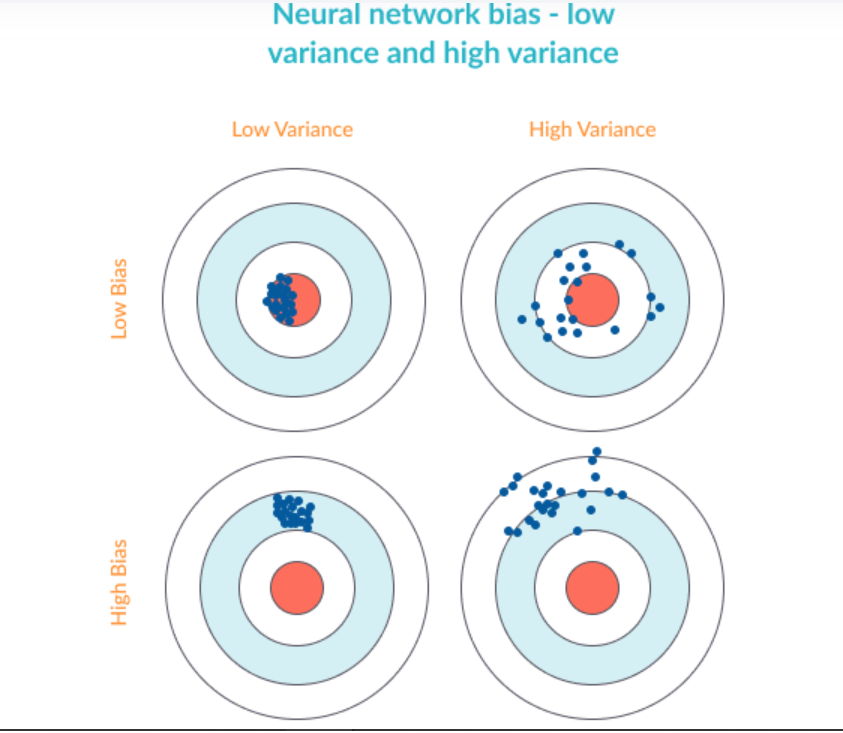

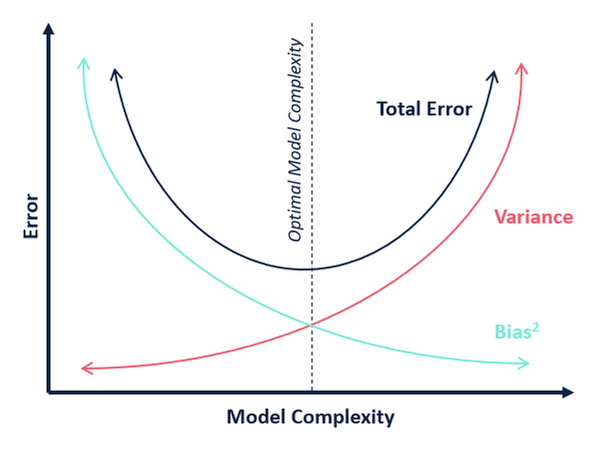

### Vizuelizacija Procesa Treninga

In [ ]:
# Nacrtaj krive treniranja i validacije
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', linewidth=2, alpha=0.8)
plt.plot(val_losses, label='Validation Loss', linewidth=2, alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Proveri prekomerno fitovanje
min_val_loss_epoch = np.argmin(val_losses)
plt.axvline(x=min_val_loss_epoch, color='red', linestyle='--', alpha=0.7,
           label=f'Min Val Loss (Epoch {min_val_loss_epoch})')

plt.subplot(1, 2, 2)
# Nacrtaj krive učenja na log skali
plt.semilogy(train_losses, label='Training Loss', linewidth=2, alpha=0.8)
plt.semilogy(val_losses, label='Validation Loss', linewidth=2, alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log scale)')
plt.title('Training Curves (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analiza
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]
min_val_loss = min(val_losses)

print(f"\n📊 Training Analysis:")
print(f"Final training loss: {final_train_loss:.6f}")
print(f"Final validation loss: {final_val_loss:.6f}")
print(f"Minimum validation loss: {min_val_loss:.6f} (epoch {min_val_loss_epoch})")
print(f"Overfitting indicator: {abs(final_val_loss - final_train_loss):.6f}")

if final_val_loss > final_train_loss * 1.1:
    print("⚠️  Possible overfitting detected!")
else:
    print("✅ Good training - no significant overfitting")

---

# **Deo 6: Evaluacija Modela**

Sada kada smo uspešno istrenirali naš model i koristili validaciju da se opredelimo za najbolji model koji smo mogli, vreme je da stvarno procenimo i izmerimo koliko dobro naš model radi.

## 6.1 Podela na Trening/Validacija/Test Skupove

Kada radimo sa stvarnim podacima, tipično ih delimo na tri dela:
1. **Skup za treniranje** – koristi se za učenje modela (optimizacija težina).
2. **Skup za validaciju** – koristi se za podešavanje modela (hiperparametri, arhitektura, dužina treniranja).
3. **Skup za testiranje** – koristi se za procenu finalnih performansi modela na potpuno neviđenim podacima.

Posmatrajte to kao učenje za ispit:
- Treniranje je vežbanje zadataka.
- Validacija je probni ispit gde još uvek možete da prilagodite plan učenja.
- Testiranje je pravi ispit gde više ne možete ništa da menjate.

## 6.2 Metrike Evaluacije za Regresiju

Kada predviđamo kontinuirane vrednosti, koristimo **metrike regresije**.

### Srednja Kvadratna Greška (MSE)

Meri prosečnu kvadratnu razliku između predviđenih i pravih vrednosti.
Kažnjava velike greške jače.

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

### Koren Srednje Kvadratne Greške (RMSE)

Kvadratni koren MSE.
Čuva iste jedinice kao ciljna varijabla, čineći je lakšom za interpretaciju.

$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

### Srednja Apsolutna Greška (MAE)

Prosek apsolutnih razlika između predviđenih i pravih vrednosti.
Manje osetljiva na izuzetke u poređenju sa MSE.

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

### Koeficijent Determinacije ($R^2$)

Govori nam koliko varijanse u ciljnoj varijabli objašnjava model. Kreće se od $-\infty$ do $1$.

$$
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$

gde je $\bar{y}$ srednja vrednost pravih vrednosti.

## 6.3 Metrike Evaluacije za Klasifikaciju

Kada predviđamo kategorije (npr. spam vs. nije spam), koristimo **metrike klasifikacije**.
One potiču od objekta koji se zove **matrica konfuzije** koja klasifikuje naše rezultate u istinito pozitivne i lažno pozitivne, i istinito negativne i lažno negativne.

edfa849b-03fb-43d2-aba5-1f53a8884e6f_image5.avif

### Tačnost

Udeo tačnih predviđanja u odnosu na sva predviđanja.

$$
\text{Accuracy} = \frac{correct\ predictions}{total\ predictions} = \frac{TP + TN}{TP + TN + FP + FN}
$$

### Preciznost

Od svih predviđenih pozitivnih, koliko je stvarno bilo pozitivno.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

### Osetljivost (Odziv)

Od svih stvarnih pozitivnih, koliko ih je tačno predviđeno.

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

### F1-Metrika

Harmonijska sredina preciznosti i osetljivosti. Balansira dve metrike kada jedna sama nije dovoljna.

$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

---

# Ključni Zaključci

## Šta smo naučili:

1. Kako da postavimo kompletan PyTorch workflow: podaci → model → gubitak → optimizator → treniranje sa validacijom → evaluacija modela
2. Kako da gradimo i pokrećemo petlje za treniranje sa forward pass-om, izračunavanjem gubitka, backward pass-om, i ažuriranjima optimizatora
3. Kako da interpretiramo metrike validacije i identifikujemo prekomerno i nedovoljno fitovanje
4. Važnost podele na trening / validaciju / test za nepristrasnu evaluaciju
5. Česte metrike regresije: MAE, MSE, RMSE
6. Česte metrike klasifikacije: Tačnost, Preciznost, Osetljivost, F1-score (sa formulama)

## Najbolje Navike:

- Uvek budite svesni svojih podataka, analizirajte ih i podelite na skupove za treniranje, validaciju i testiranje.
- Pronađite pravu meru između krutosti i fleksibilnosti vašeg modela (Kompromis pristranosti i varijanse)
- Kada koristite podatke da merite performanse i podešavate model na osnovu toga, stvarate pristranost prema tim podacima.
- Ne bojte se da koristite više metrika.

## Sledeći koraci:

U sledećem odeljku, primenićemo sve na konkretnom problemu klasifikacije u fizici. Pripremićemo naše podatke, izgraditi model, izabrati najbolju funkciju gubitka i optimizator, trenirati sa validacijom, i testirati naš model.

---

# Samostalni Rad

## Zadaci

Klasifikacija u praksi:
Pokušajte da implementirate sve što ste do sada naučili da kreirate klasifikator koji predviđa da li student prolazi (1) ili pada (0) na ispitu.

1. Napravite mali lažni dataset za binarnu klasifikaciju. Karakteristike:
  - hours_Studied (kontinuirane, 0–10): Normalno distribuirane sa srednjom vrednošću i std zavisnim od klasa
    - Neuspeh (0): ~𝒩(3, 1)
    - Prolaz (1): ~𝒩(7, 1.5)
  - attendance (kategoričke: Low, Medium, High → kodirane kao 0/1/2)
    - Neuspeh (0): Uglavnom Low/Medium (70% low, 30% medium)
    - Prolaz (1): Uglavnom Medium/High (40% medium, 60% high)
  - sleep_Hours (kontinuirane, 4–9): Normalno distribuirane sa srednjom vrednošću i std zavisno od labela.
    - Neuspeh (0): ~𝒩(5.5, 1)
    - Prolaz (1): ~𝒩(7, 1)

2. Istrenirajte jednostavan model - malu neuronsku mrežu sa 2-3 skrivena sloja veličine po vašem izboru. Možete zanemariti podelu na validaciju. Koju funkciju gubitka ćete izabrati za binarnu klasifikaciju?

3. Napravite matricu konfuzije i izračunajte Tačnost, Preciznost, Osetljivost i F1-score koristeći PyTorch ili sklearn.metrics.

4. Uporedite metrike i objasnite zašto tačnost možda nije uvek najbolja metrika.

In [ ]:
# Mesto za rešavanje Zadatka 1

In [ ]:
# Mesto za rešavanje Zadatka 2

In [ ]:
# Mesto za rešavanje Zadatka 3

In [ ]:
# Mesto za rešavanje Zadatka 4

---

## Rešenja

In [ ]:
# -------- Zadatak 1 --------
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

rng = np.random.default_rng(42)

# ----------------------------------------------------
# Konfiguracija
# ----------------------------------------------------
N = 2000                      # ukupno uzoraka
pass_ratio = 0.5              # balans klasa; menjaj da testiraš efekte nebalansiranosti
N1 = int(N * pass_ratio)      # Prolaz (1)
N0 = N - N1                   # Neuspeh (0)

# ----------------------------------------------------
# Generiši karakteristike prema specifikaciji
# ----------------------------------------------------
# Hours_Studied
hours_fail = rng.normal(loc=3.0, scale=1.0, size=N0)
hours_pass = rng.normal(loc=7.0, scale=1.5, size=N1)

# Attendance (0=Low, 1=Medium, 2=High)
# Neuspeh: 70% Low, 30% Medium, 0% High (implicitno)
att_fail = rng.choice([0,1], size=N0, p=[0.7, 0.3])
# Prolaz: 40% Medium, 60% High (implicitno; 0% Low)
att_pass = rng.choice([1,2], size=N1, p=[0.4, 0.6])

# Sleep_Hours
sleep_fail = rng.normal(loc=5.5, scale=1.0, size=N0)
sleep_pass = rng.normal(loc=7.0, scale=1.0, size=N1)

# Ograniči na zahtevane izvodljive opsege
hours_fail = np.clip(hours_fail, 0, 10)
hours_pass = np.clip(hours_pass, 0, 10)
sleep_fail = np.clip(sleep_fail, 4, 9)
sleep_pass = np.clip(sleep_pass, 4, 9)

# Spoji karakteristike i oznake klasa
X0 = np.stack([hours_fail, att_fail, sleep_fail], axis=1)
X1 = np.stack([hours_pass, att_pass, sleep_pass], axis=1)
X = np.vstack([X0, X1]).astype(np.float32)
y = np.hstack([np.zeros(N0, dtype=np.int64), np.ones(N1, dtype=np.int64)])

# Podela na trening/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Opciono: standardizuj samo kontinuirane karakteristike (kolone 0 i 2)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_cont = scaler.fit_transform(X_train[:, [0,2]])
X_test_cont  = scaler.transform(X_test[:, [0,2]])

# Zadrži attendance kakav jeste (kategoričko kodirano 0/1/2)
X_train_proc = np.column_stack([X_train_cont, X_train[:,1]])
X_test_proc  = np.column_stack([X_test_cont , X_test[:,1]])

In [ ]:
# -------- Zadatak 2 --------
# Konvertuj u tenzore
Xtr = torch.tensor(X_train_proc, dtype=torch.float32)
ytr = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
Xte = torch.tensor(X_test_proc , dtype=torch.float32)
yte = torch.tensor(y_test.reshape(-1,1), dtype=torch.float32)

# Mala neuronska mreža (2–3 skrivena sloja)
net = nn.Sequential(
    nn.Linear(3, 16), nn.ReLU(),
    nn.Linear(16, 8), nn.ReLU(),
    nn.Linear(8, 1)   # jedan logit
)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Treniraj
net.train()
for epoch in range(400):
    optimizer.zero_grad()
    logits = net(Xtr)
    loss = criterion(logits, ytr)
    loss.backward()
    optimizer.step()

# Testiraj
net.eval()
with torch.no_grad():
    logits_te = net(Xte)
    probs_te = torch.sigmoid(logits_te).cpu().numpy().ravel()

y_pred = (probs_te >= 0.5).astype(int)   # default prag prolaza

In [ ]:
# -------- Zadatak 3 --------
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, * = precision*recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)

print("Confusion Matrix:\n", cm)
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")

# Brz pregled da vidimo kako se metrike menjaju sa pragom prolaza
thresholds = np.linspace(0.1, 0.9, 9)
rows = []
for t in thresholds:
    yp = (probs_te >= t).astype(int)
    a = accuracy_score(y_test, yp)
    p, r, f, * = precision*recall_fscore_support(y_test, yp, average='binary', zero_division=0)
    rows.append((t, a, p, r, f))

print("\nThreshold  Acc   Prec  Rec   F1")
for t,a,p,r,f in rows:
    print(f"{t:8.2f}  {a:0.3f} {p:0.3f} {r:0.3f} {f:0.3f}")

In [ ]:
# -------- Zadatak 4 --------
'''
Zašto tačnost možda nije najbolja metrika:
- Nebalans klasa: Ako 90% studenata prolazi, glup klasifikator koji predviđa "prolaz" za sve dobija 90% tačnost ali 0 osetljivost na manjinskoj klasi (padovi). Preciznost/Osetljivost/F1 otkrivaju tu slabost.
- Različiti troškovi grešaka: U mnogim obrazovnim okruženjima, obaranje studenta koji je položio ispit (lažno negativan) je gore od puštanja onog koji nije (lažno pozitivan). Tačnost ih tretira jednako; Preciznost/Osetljivost/F1 omogućavaju da se naglasi ono što je važno.
- Osetljivost na prag: Tačnost zavisi od praga 0.5. Ako treba da se maksimizuje osetljivost (uhvati što više studenata koji su navodno pali), možete sniziti prag i pratiti kompromis Preciznost/Osetljivost/F1.
- Kvalitet verovatnoće se ignoriše: Tačnost ignoriše koliko je model siguran. Metrike kalibracije (npr., Brier score) i PR/ROC analiza mogu biti informativnije za donošenje odluka.
'''